In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import numpy as np

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Load the networks

In [2]:
networks = [
    # load_NN('predicter_master.json'),
    # load_NN('tailored_geometry.json'),
    load_NN('raw_geometry_uniform.json'),
    # load_NN('tailored_geometry_uniform.json'),
    load_NN('tailored_geometry_ybias100.json'),
    # load_NN('geometry_ybias_adaptive.json'),
    # load_NN('geometry_ybias_adaptive_2.json'),
    # load_NN('geometry_ybias_adaptive_3.json'),
    load_NN('geometry_ybias_adaptive_4.json'),
    load_NN('geometry_ybias_adaptive_7.json'),
    load_NN('geometry_ybias_adaptive_8.json'),
]
names = [
    # 'predicter master',
    # 'tailored geometry',
    'raw geometry uniform',
    # 'tailored geometry uniform',
    'tailored geometry ybias100',
    # 'geometry y-bias adaptive',
    # 'geometry y-bias adaptive v2',
    # 'geometry y-bias adaptive v3',
    'geometry y-bias adaptive v4',
    'geometry y-bias adaptive v7',
    'geometry y-bias adaptive v7+',
]

# Initialize the QEC code that will be used

Rate of non-trivial cases: 53.30%


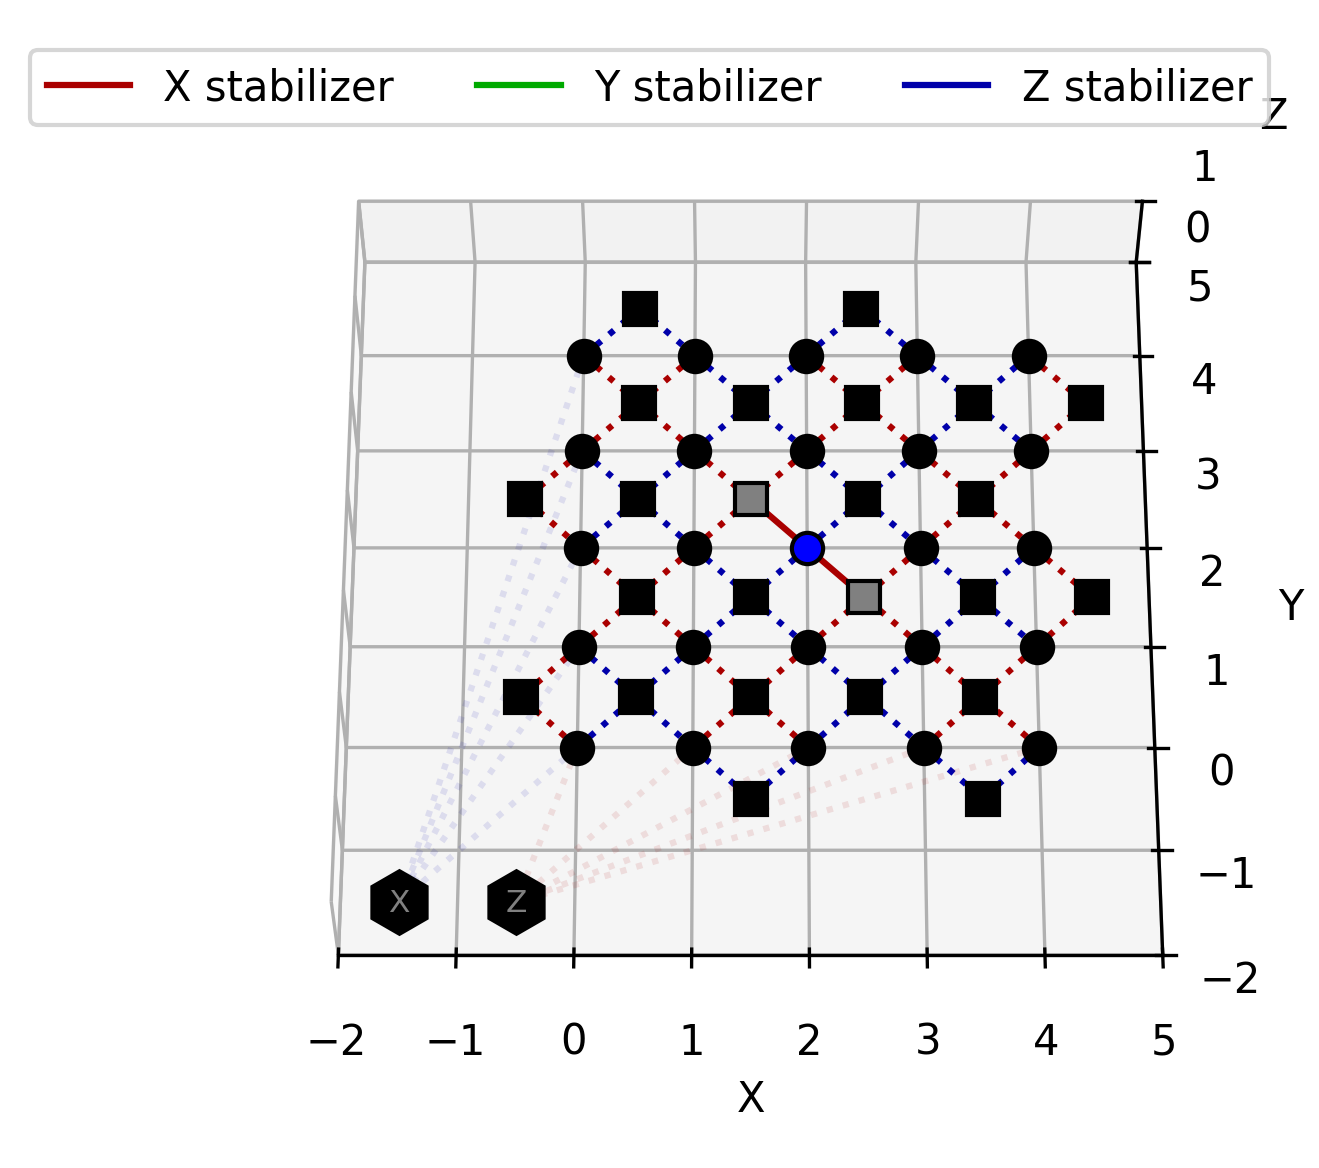

In [3]:
error_prob = [.0025, .025, .0025]
code_distance = 5

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=1, key=subkey)

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
info['Mx'], info['My'], info['Mz'] = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
info['Sx'], info['Lx'] = info['Mx'][:-2], info['Mx'][-2:]
info['Sy'], info['Ly'] = info['My'][:-2], info['My'][-2:]
info['Sz'], info['Lz'] = info['Mz'][:-2], info['Mz'][-2:]
nsq, ndq = info['Sx'].shape
qec.show(errors=errors[0]);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

# Create the NN

In [4]:
def NN(x, params):
    # Change from 0, 1 inputs to -1, 1
    x = 2*x - 1

    num_layers = len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
        x = jnp.matmul(w, x) + b
        if layer_idx < num_layers-1:
            x = jax.nn.relu(x)
    return x


def NN2(syndromes, error_weights, params):
    # Change from 0, 1 inputs to -1, 1
    syndromes = jnp.append(2*syndromes - 1, error_weights)

    num_layers = len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
        syndromes = jnp.matmul(w, syndromes) + b
        if layer_idx < num_layers-1:
            syndromes = jax.nn.relu(syndromes)
    return syndromes


NN_batch = jax.vmap(NN, in_axes=[0, None], out_axes=0)
NN2_batch = jax.vmap(NN2, in_axes=[0, None, None], out_axes=0)

# Create data function

In [5]:
def jax_create_error_batch(px: float, py: float, pz: float, size: int, batch_size: int, key) -> jnp.ndarray:
    rand = jax.random.uniform(key, shape=(batch_size, size))
    result = jnp.zeros_like(rand, dtype=jnp.int32)  # Initialize with zeros (default case)

    # Apply conditions sequentially
    result = jnp.where(rand < px + py + pz, 1, result)  # Check for px+py+pz first
    result = jnp.where(rand < py + pz, 2, result)      # Check for py+pz next
    result = jnp.where(rand < pz, 3, result)          # Check for pz last

    return result

def gen_data(error_prob: list, info: dict, ndq: int, batch_size: int, key):
    errors = jax_create_error_batch(*error_prob, size=ndq, batch_size=batch_size, key=key)

    syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
    logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

    return syndromes, logicals

subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=10, key=subkey)

# Benchmark the NN's

#### Function of total physical error probability

In [6]:
nu = 1/2

ps = jnp.logspace(-4, jnp.log10(.2), 100)
NN_rates = jnp.zeros(shape=(len(networks), 3, ps.shape[0]))
MWPM_rates = jnp.zeros(shape=(3, ps.shape[0]))
for i, p in enumerate(ps):
    # Generate data
    batch_size = 1_000_000
    error_prob = [
        1 / (2 * (nu + 1)) * p,
        nu / (nu + 1) * p,
        1 / (2 * (nu + 1)) * p,
    ]
    error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
    subkey, key = jax.random.split(key)
    syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=batch_size, key=subkey)

    for j, params in enumerate(networks):
        # Run the neural network and round it's prediction to the nearest integer
        if 'adaptive' in names[j]:
            NN_probs = jax.nn.sigmoid(NN2_batch(syndromes, error_weights, params))
        else:
            NN_probs = jax.nn.sigmoid(NN_batch(syndromes, params))
        NN_logicals = jnp.where(NN_probs>0.5, 1, 0)

        NN_errors = (logicals+NN_logicals)%2
        NN_rates = NN_rates.at[j,0,i].set(jnp.equal(NN_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size)
        NN_rates = NN_rates.at[j,1,i].set(jnp.equal(NN_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size)
        NN_rates = NN_rates.at[j,2,i].set(jnp.equal(NN_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size)

    # Evaluate the MWPM decoder on the same dataset
    MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
    decoding = MWPM.decode_batch(syndromes)
    recovery = jnp.where(decoding[:,:ndq]==1, jnp.where(decoding[:,ndq:]==1, 2, 1), jnp.where(decoding[:,ndq:]==1, 3, 0))
    MWPM_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)
    MWPM_errors = (logicals+MWPM_logicals)%2
    MWPM_rates = MWPM_rates.at[0,i].set(jnp.equal(MWPM_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size)
    MWPM_rates = MWPM_rates.at[1,i].set(jnp.equal(MWPM_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size)
    MWPM_rates = MWPM_rates.at[2,i].set(jnp.equal(MWPM_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size)

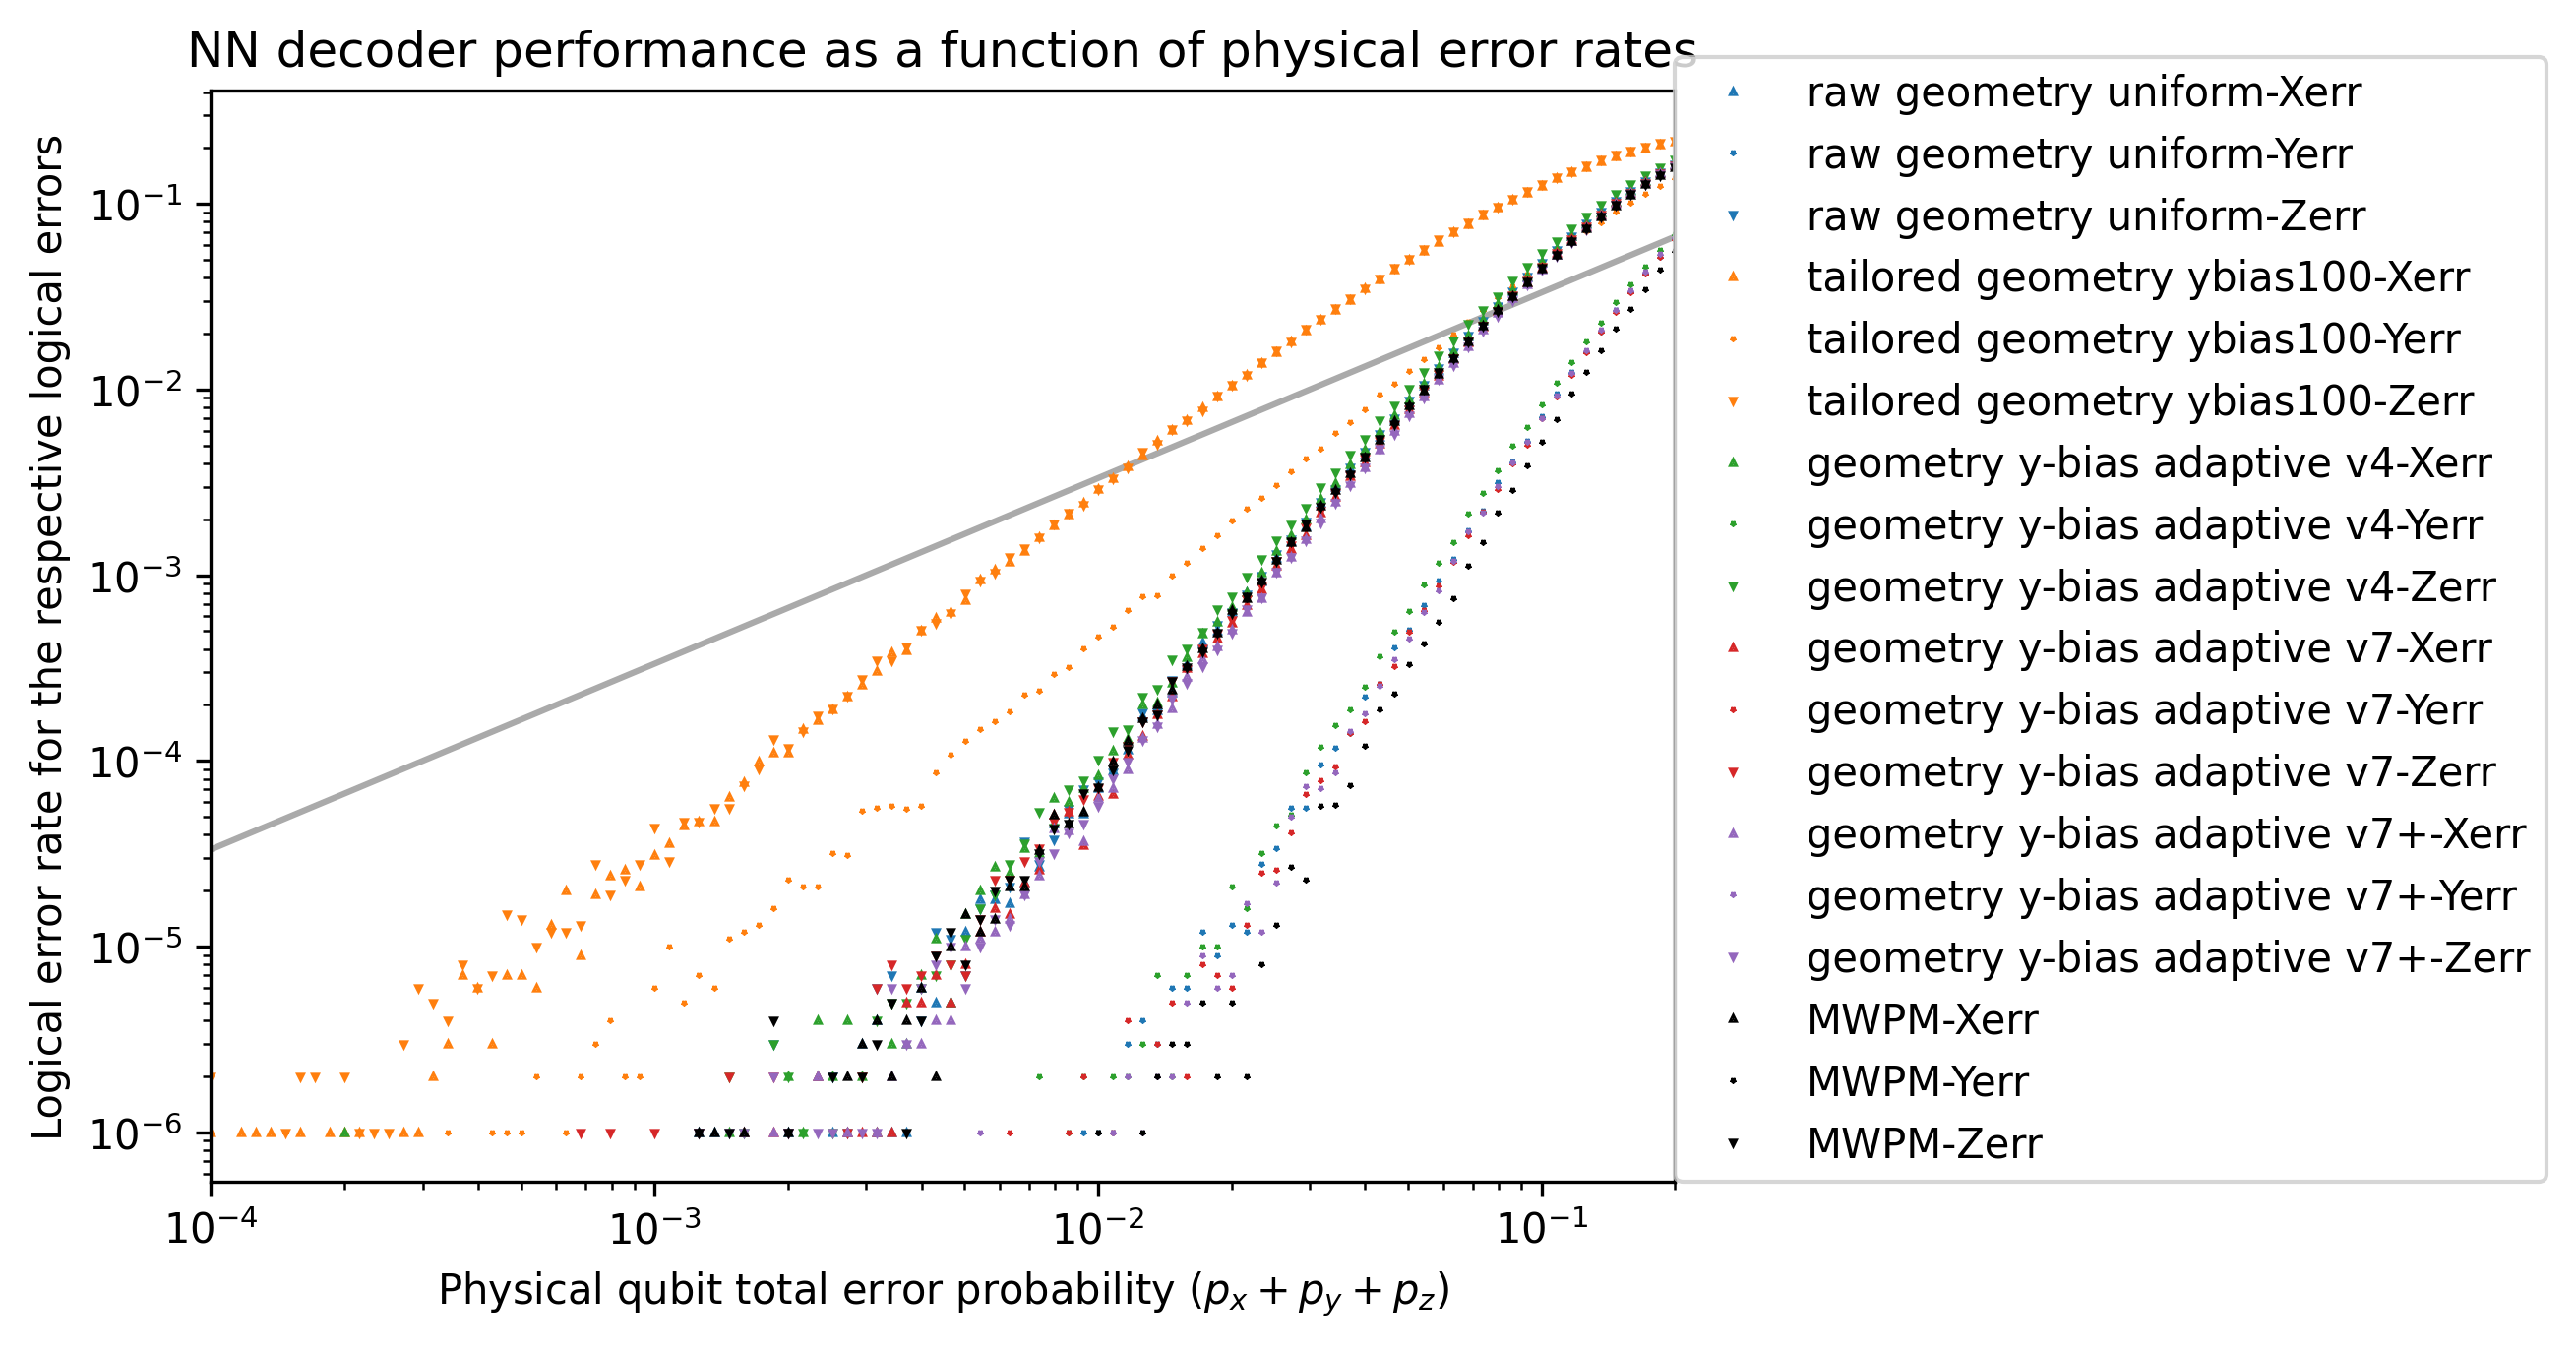

In [7]:
plt.figure(dpi=300)
plt.plot(ps, ps/3, color='#aaaaaa')
for i in range(len(networks)):
    plt.plot(ps, NN_rates[i,0], '^', ms=1, c=f'C{i}', lw=.5, label=f'{names[i]}-Xerr')
    plt.plot(ps, NN_rates[i,1], '*', ms=1, c=f'C{i}', lw=.5, label=f'{names[i]}-Yerr')
    plt.plot(ps, NN_rates[i,2], 'v', ms=1, c=f'C{i}', lw=.5, label=f'{names[i]}-Zerr')
plt.plot(ps, MWPM_rates[0], '^', ms=1, c='k', lw=.5, label='MWPM-Xerr')
plt.plot(ps, MWPM_rates[1], '*', ms=1, c='k', lw=.5, label='MWPM-Yerr')
plt.plot(ps, MWPM_rates[2], 'v', ms=1, c='k', lw=.5, label='MWPM-Zerr')
plt.xscale('log')
plt.yscale('log')
plt.xlim(ps.min(), ps.max())
plt.legend(loc = (1,0))
plt.xlabel('Physical qubit total error probability ($p_x + p_y + p_z$)')
plt.ylabel('Logical error rate for the respective logical errors')
plt.title('NN decoder performance as a function of physical error rates')
plt.show()

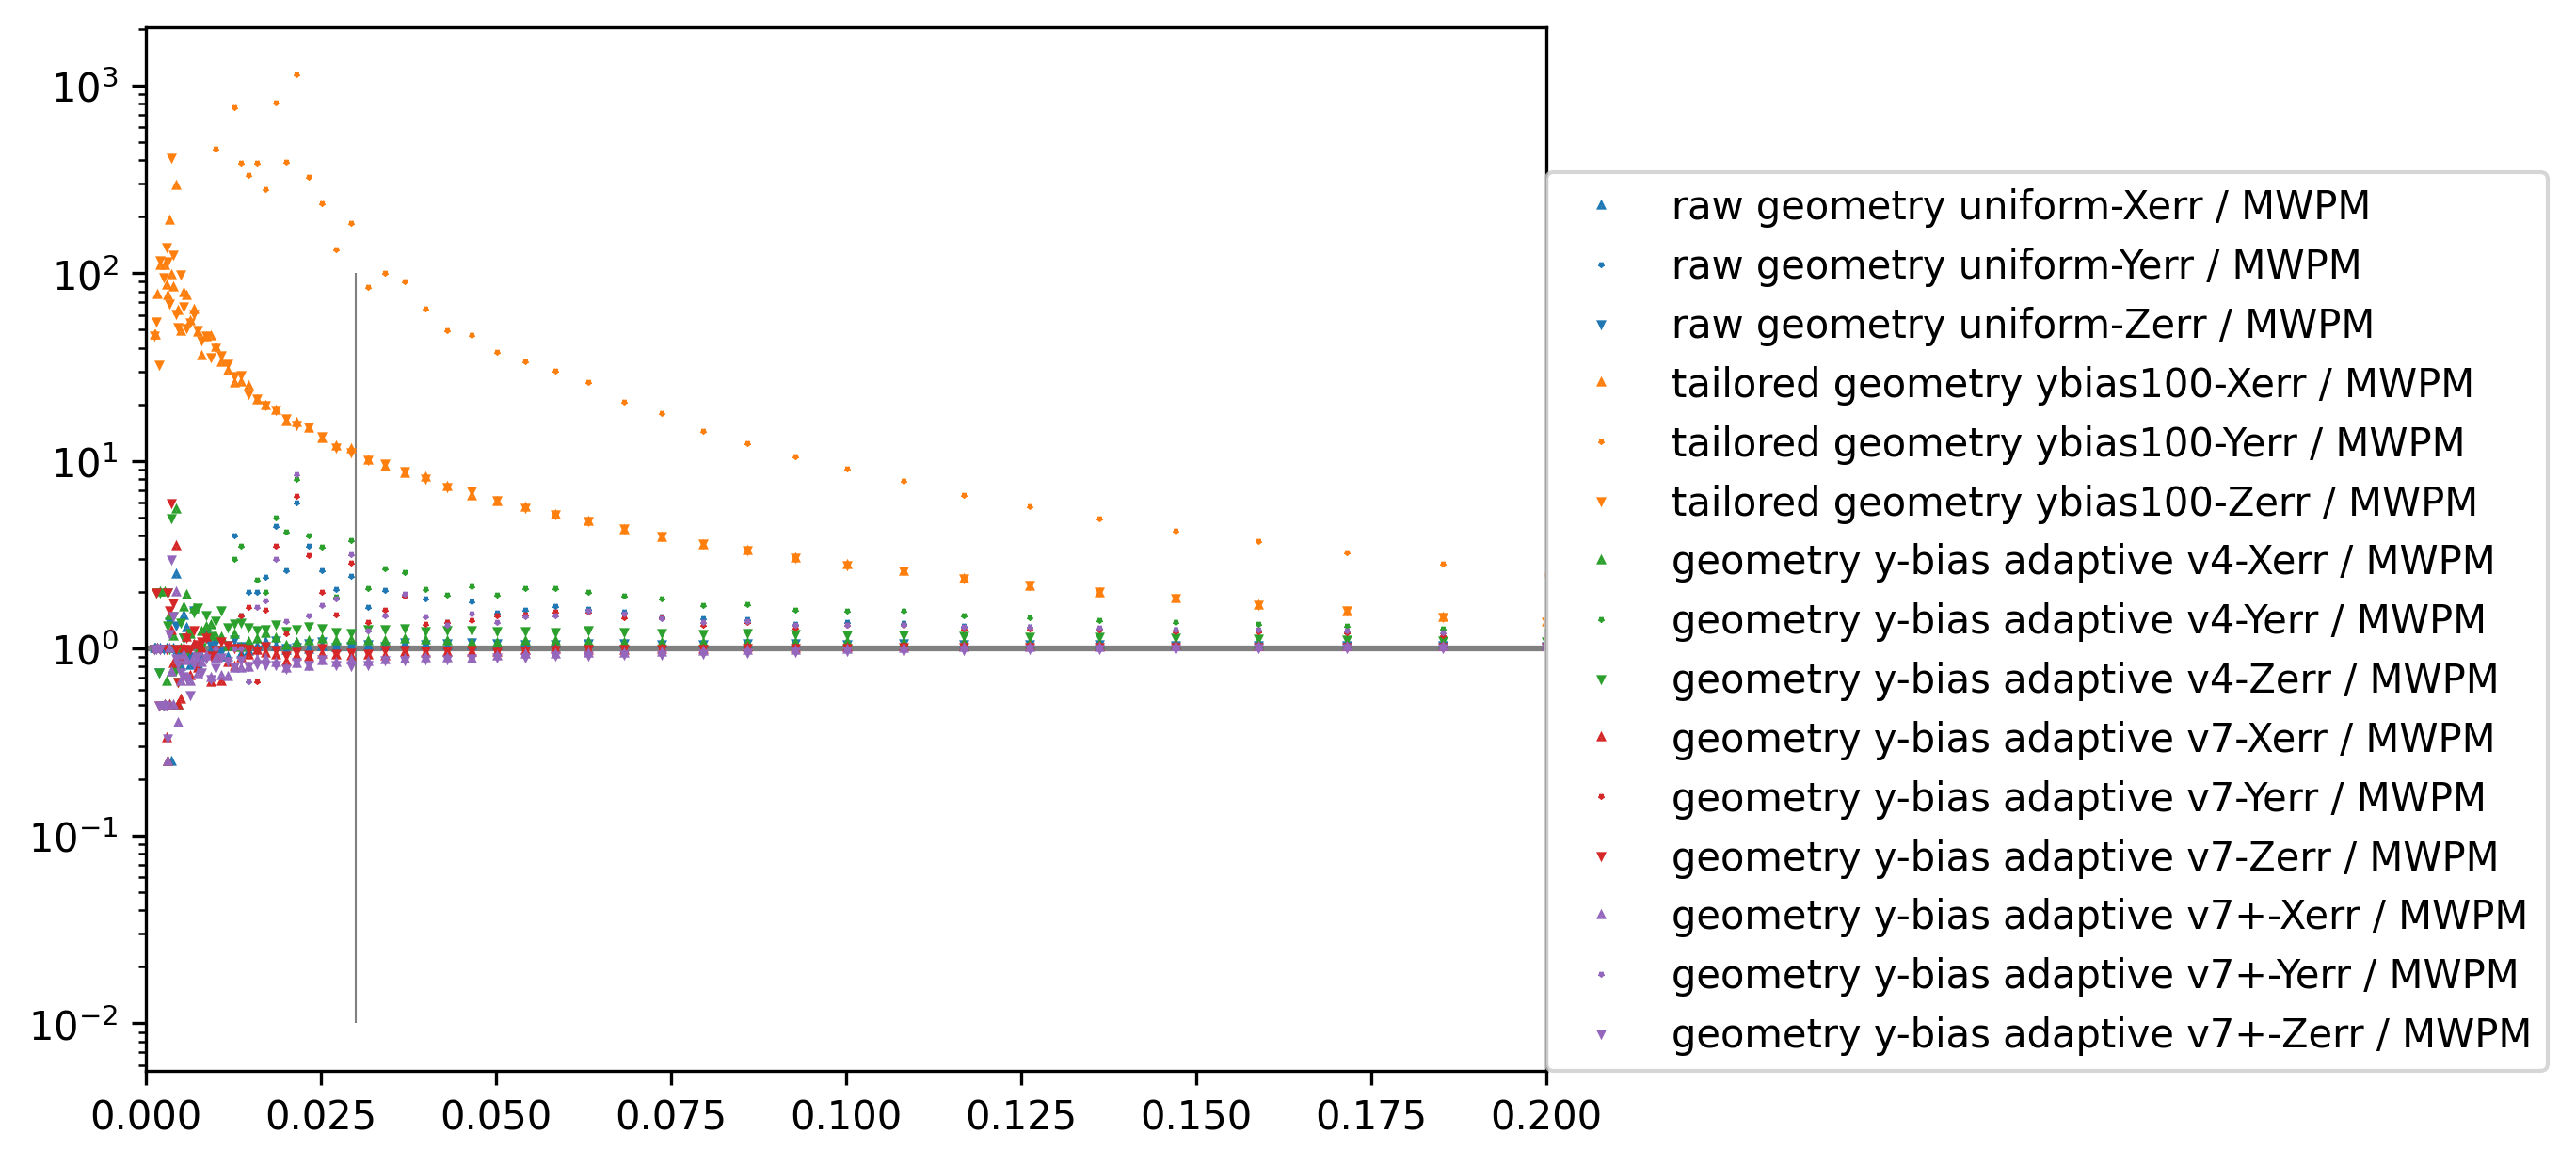

In [8]:
plt.figure(dpi=300)
plt.hlines([1], [ps.min()], [ps.max()], color='gray')
plt.vlines([.03], [1E-2], [1E2], color='gray', lw=.5)
for i in range(len(networks)):
    plt.plot(ps, NN_rates[i,0] / MWPM_rates[0], '^', ms=1, c=f'C{i}', label=f'{names[i]}-Xerr / MWPM')
    plt.plot(ps, NN_rates[i,1] / MWPM_rates[1], '*', ms=1, c=f'C{i}', label=f'{names[i]}-Yerr / MWPM')
    plt.plot(ps, NN_rates[i,2] / MWPM_rates[2], 'v', ms=1, c=f'C{i}', label=f'{names[i]}-Zerr / MWPM')
    # plt.plot(ps, NN_rates[i,0] / MWPM_rates[0], ':', c=f'C{i}', label=f'{names[i]}-Xerr / MWPM-decoder-performance')
    # plt.plot(ps, NN_rates[i,1] / MWPM_rates[1], '-.', c=f'C{i}', label=f'{names[i]}-Yerr / MWPM-decoder-performance')
    # plt.plot(ps, NN_rates[i,2] / MWPM_rates[2], '--', c=f'C{i}', label=f'{names[i]}-Zerr / MWPM-decoder-performance')
# plt.xscale('log')
plt.yscale('log')
# plt.ylim(0, 5)
plt.xlim(0, ps.max())
plt.legend(loc = (1,0))
plt.show()

#### Function of total physical error y-bias

In [9]:
p = 0.03

nus = jnp.logspace(jnp.log10(1/2), jnp.log10(100), 100)
NN_rates = jnp.zeros(shape=(len(networks), 3, ps.shape[0]))
MWPM_rates = jnp.zeros(shape=(3, ps.shape[0]))
for i, nu in enumerate(nus):
    # Generate data
    batch_size = 1_000_000
    error_prob = [
        1 / (2 * (nu + 1)) * p,
        nu / (nu + 1) * p,
        1 / (2 * (nu + 1)) * p,
    ]
    error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
    subkey, key = jax.random.split(key)
    syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=batch_size, key=subkey)

    for j, params in enumerate(networks):
        # Run the neural network and round it's prediction to the nearest integer
        if 'adaptive' in names[j]:
            NN_probs = jax.nn.sigmoid(NN2_batch(syndromes, error_weights, params))
        else:
            NN_probs = jax.nn.sigmoid(NN_batch(syndromes, params))
        NN_logicals = jnp.where(NN_probs>0.5, 1, 0)

        NN_errors = (logicals+NN_logicals)%2
        NN_rates = NN_rates.at[j,0,i].set(jnp.equal(NN_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size)
        NN_rates = NN_rates.at[j,1,i].set(jnp.equal(NN_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size)
        NN_rates = NN_rates.at[j,2,i].set(jnp.equal(NN_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size)

    # Evaluate the MWPM decoder on the same dataset
    MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
    decoding = MWPM.decode_batch(syndromes)
    recovery = jnp.where(decoding[:,:ndq]==1, jnp.where(decoding[:,ndq:]==1, 2, 1), jnp.where(decoding[:,ndq:]==1, 3, 0))
    MWPM_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)
    MWPM_errors = (logicals+MWPM_logicals)%2
    MWPM_rates = MWPM_rates.at[0,i].set(jnp.equal(MWPM_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size)
    MWPM_rates = MWPM_rates.at[1,i].set(jnp.equal(MWPM_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size)
    MWPM_rates = MWPM_rates.at[2,i].set(jnp.equal(MWPM_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size)

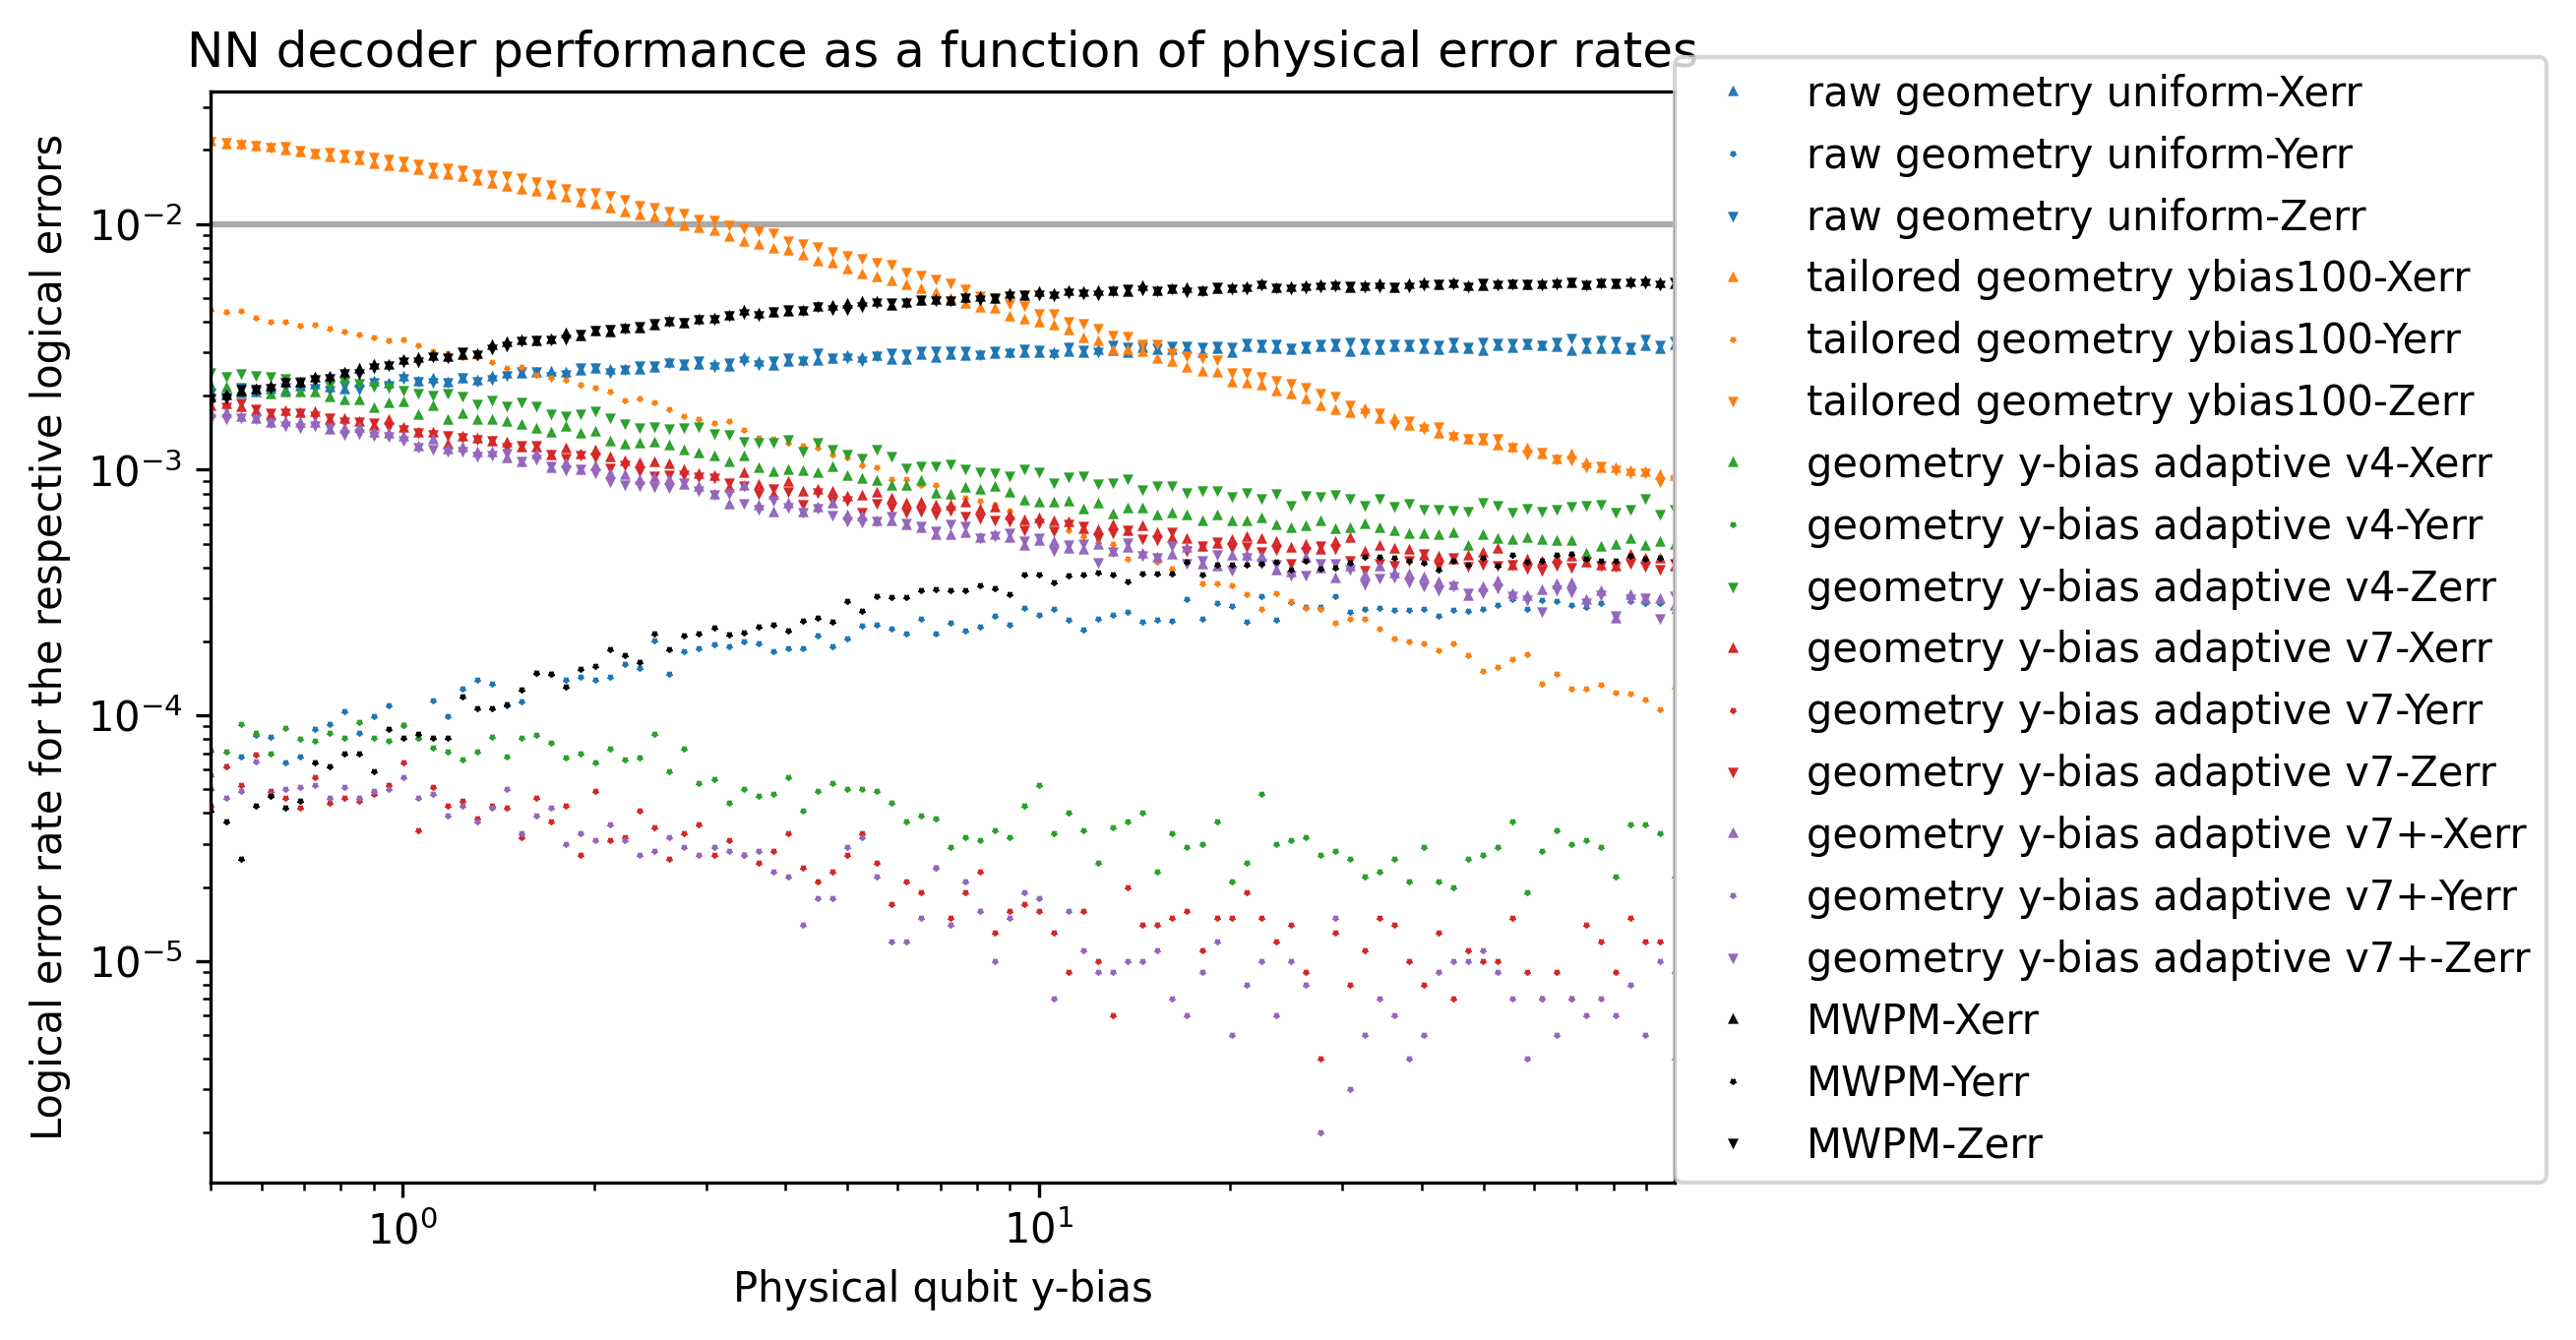

In [10]:
plt.figure(dpi=300)
plt.plot(nus, jnp.ones_like(nus)*p/3, color='#aaaaaa')
for i in range(len(networks)):
    plt.plot(nus, NN_rates[i,0], '^', ms=1, c=f'C{i}', lw=.5, label=f'{names[i]}-Xerr')
    plt.plot(nus, NN_rates[i,1], '*', ms=1, c=f'C{i}', lw=.5, label=f'{names[i]}-Yerr')
    plt.plot(nus, NN_rates[i,2], 'v', ms=1, c=f'C{i}', lw=.5, label=f'{names[i]}-Zerr')
plt.plot(nus, MWPM_rates[0], '^', ms=1, c='k', lw=.5, label='MWPM-Xerr')
plt.plot(nus, MWPM_rates[1], '*', ms=1, c='k', lw=.5, label='MWPM-Yerr')
plt.plot(nus, MWPM_rates[2], 'v', ms=1, c='k', lw=.5, label='MWPM-Zerr')
plt.xscale('log')
plt.yscale('log')
plt.xlim(nus.min(), nus.max())
plt.legend(loc = (1,0))
plt.xlabel('Physical qubit y-bias')
plt.ylabel('Logical error rate for the respective logical errors')
plt.title('NN decoder performance as a function of physical error rates')
plt.show()

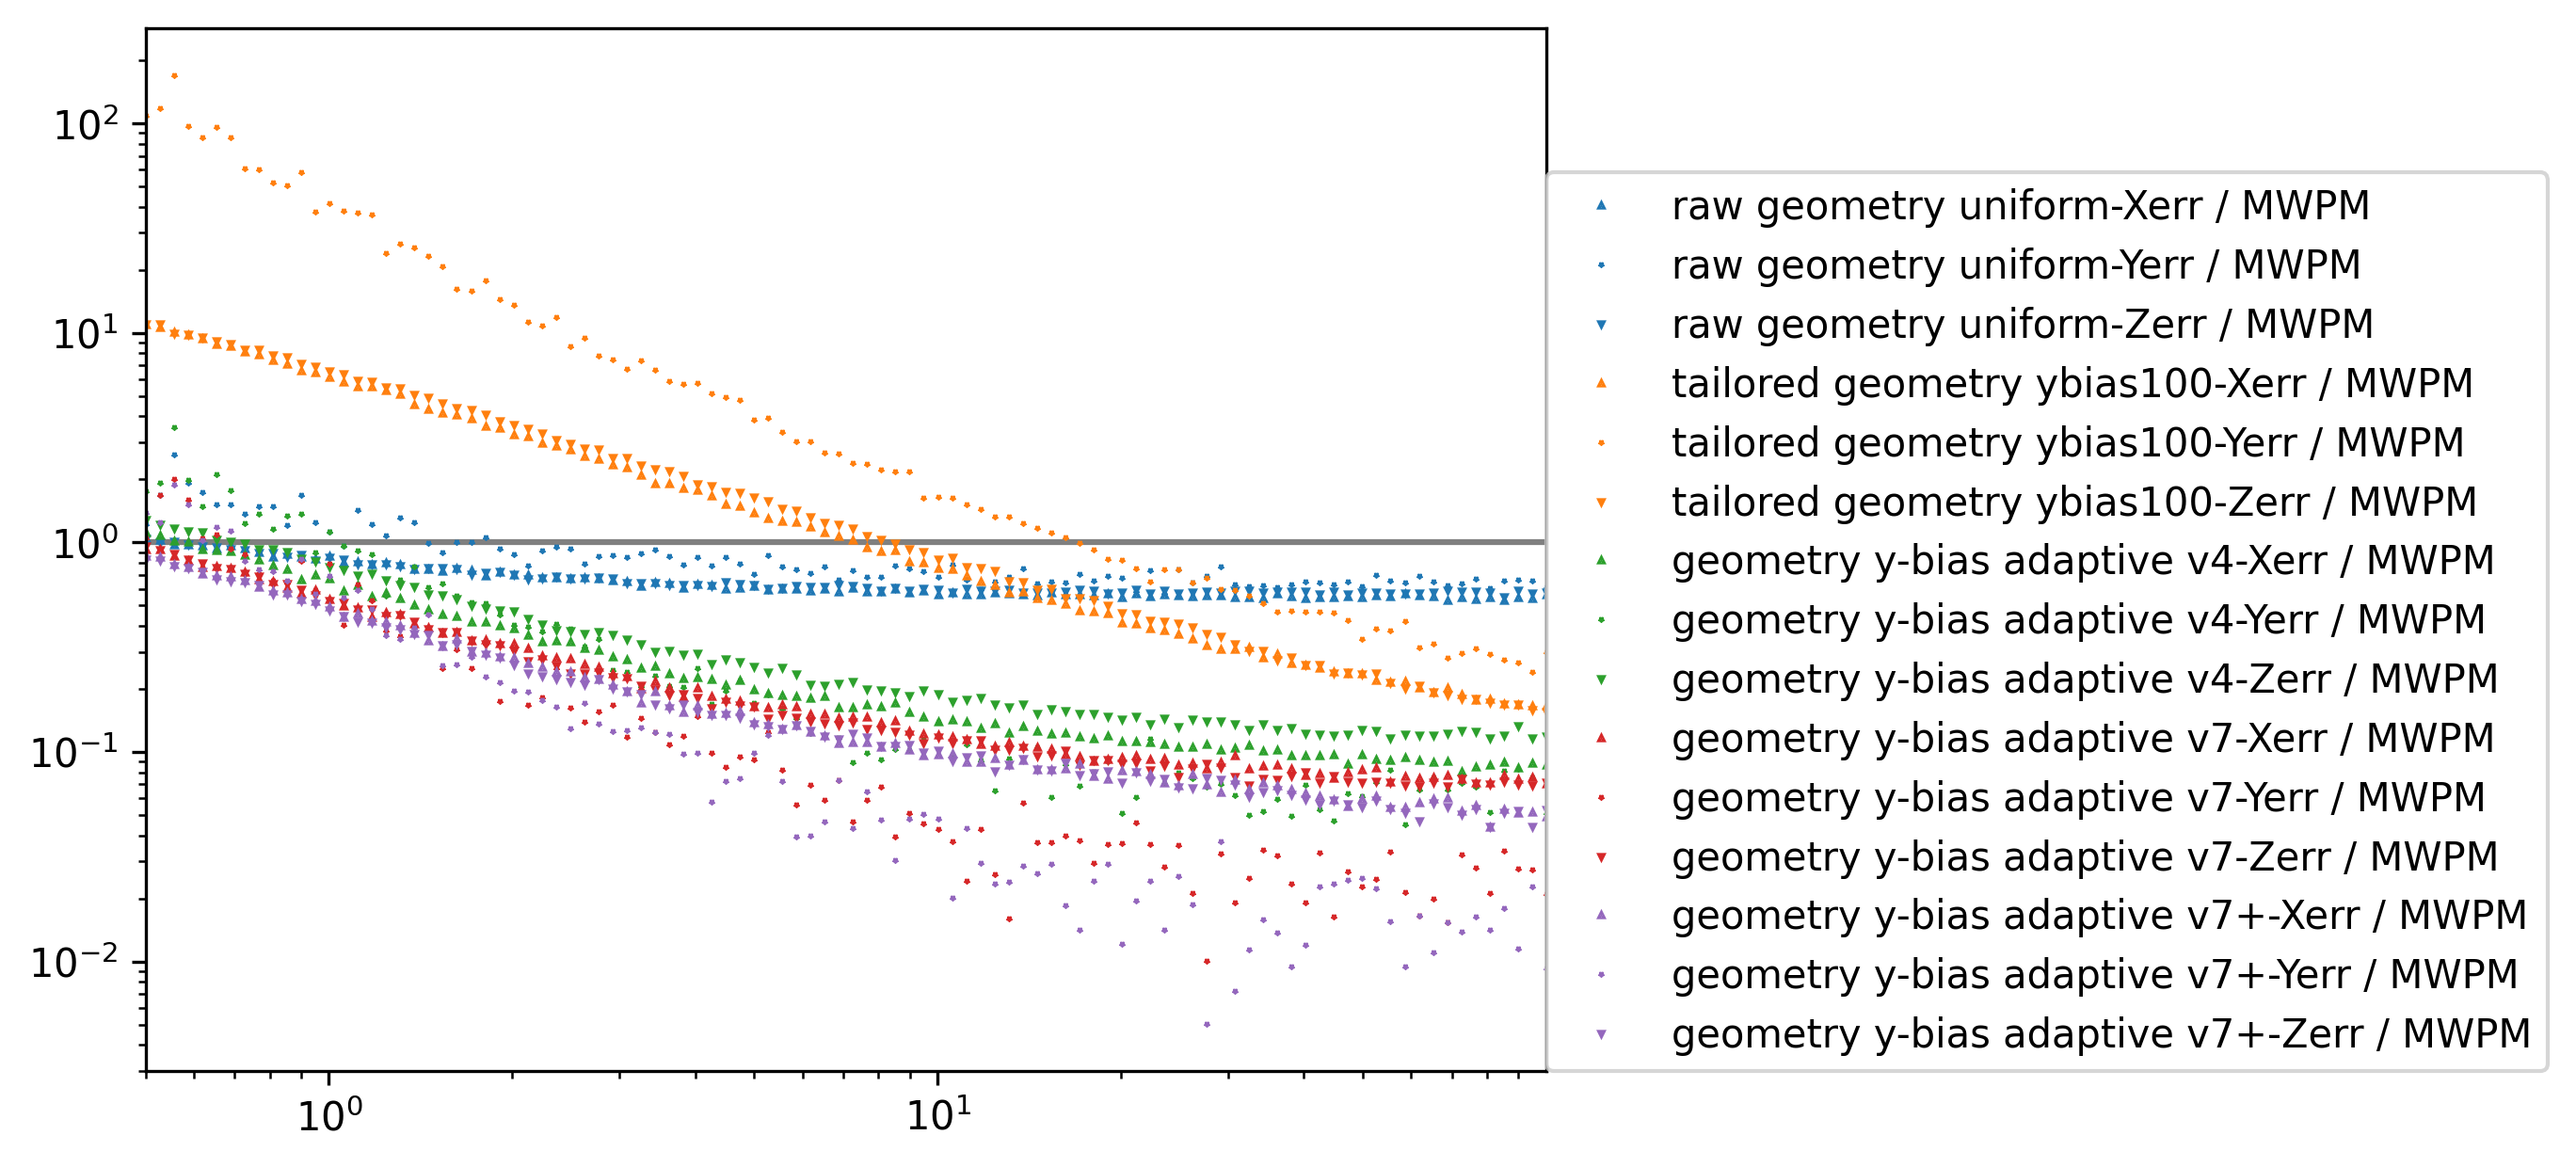

In [11]:
plt.figure(dpi=300)
plt.hlines([1], [nus.min()], [nus.max()], color='gray')
for i in range(len(networks)):
    plt.plot(nus, NN_rates[i,0] / MWPM_rates[0], '^', ms=1, c=f'C{i}', label=f'{names[i]}-Xerr / MWPM')
    plt.plot(nus, NN_rates[i,1] / MWPM_rates[1], '*', ms=1, c=f'C{i}', label=f'{names[i]}-Yerr / MWPM')
    plt.plot(nus, NN_rates[i,2] / MWPM_rates[2], 'v', ms=1, c=f'C{i}', label=f'{names[i]}-Zerr / MWPM')
    # plt.plot(ps, NN_rates[i,0] / MWPM_rates[0], ':', c=f'C{i}', label=f'{names[i]}-Xerr / MWPM-decoder-performance')
    # plt.plot(ps, NN_rates[i,1] / MWPM_rates[1], '-.', c=f'C{i}', label=f'{names[i]}-Yerr / MWPM-decoder-performance')
    # plt.plot(ps, NN_rates[i,2] / MWPM_rates[2], '--', c=f'C{i}', label=f'{names[i]}-Zerr / MWPM-decoder-performance')
plt.xscale('log')
plt.yscale('log')
plt.xlim(nus.min(), nus.max())
# plt.xlim(0, ps.max())
plt.legend(loc = (1,0))
plt.show()